# Introduction

This Notebook allow to create and visualize the dataset for this project.

Some functions was taked from "Visión por computadora" workshop by Mauricio Repetto & Waldemar López 

(https://drive.google.com/file/d/1neqSeyIqdpufL4EtY6jUirUvWGya0Mkp/view?usp=sharing)


# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv

from shutil import copy2, rmtree, copytree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname, abspath
from inspect import getsourcefile
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Downloading dataset from Github

In [2]:
![ ! -d "dataset" ] && echo "Cloning dataset project from github" && git clone https://github.com/alphonse92/momo-dataset.git ./dataset 
!cd dataset && git reset --hard && git pull && git checkout V2

Cloning dataset project from github
Cloning into './dataset'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1432 (delta 0), reused 4 (delta 0), pack-reused 1427
Receiving objects: 100% (1432/1432), 219.09 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (15/15), done.
HEAD is now at 7e7bb4a remove ds store
Already up to date.
Updating files: 100% (1461/1461), done.
Branch 'V2' set up to track remote branch 'V2' from 'origin'.
Switched to a new branch 'V2'


In [3]:
# Load Inception V3.

InceptionV3             = keras.applications.inception_v3.InceptionV3
     
preprocess_input        = keras.applications.inception_v3.preprocess_input
image                   = keras.preprocessing.image
     
ImageDataGenerator      = keras.preprocessing.image.ImageDataGenerator
Callback                = keras.callbacks
     
Model                   = keras.models.Model
Sequential              = keras.models.Sequential
layers                  = keras.layers
     
Input                   = layers.Input
Dense                   = layers.Dense
Conv2D                  = layers.Conv2D
ZeroPadding2D           = layers.ZeroPadding2D
BatchNormalization      = layers.BatchNormalization
AveragePooling2D        = layers.AveragePooling2D
MaxPooling2D            = layers.MaxPooling2D
GlobalAveragePooling2D  = layers.GlobalAveragePooling2D




In [4]:
inceptionV3Model = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')

# Uncomment to describe the inception v3 summary model
#print(inceptionV3Model.summary())

# Notebook Configuration 


In [5]:
# Notebook Configuration
USE_INCEPTION_V3_MODEL = True
RESET_TRAINING_EXAMPLES = True
SAVE_WEIGHTS = True
SEED_APP = 9

# DATASET PROPORTIONS
TRAINING_PERCENTAGE = 0.7
TESTING_PERCENTAGE  = 0.15
EVAL_PERCENTAGE     = 0.15

# HYPERPARAMETERS
CRITERIA_THRESHOLD = 0.1
EPOCHS = 25
BATCH_SIZE = 15
IMG_W = IMG_H = 299

# MODEL CHECKPOINTS CONFIGURATION
SAVE_CHECKPOINTS = 5
SAVE_WEIGHTS_FREQUENCY = 'epoch'
SAVE_WEIGTHS_PERIOD = EPOCHS // SAVE_CHECKPOINTS

# COLAB SCOPE
GOOGLE_COLLAB = False                                                            # Default value. You should not modify this
GOOGLE_RESET_CONTENT_TREE = True                                                 # Reset the dataset content tree. It means remove and re copy the data from drive
MOUNT = "./"                                                                     # Base path of this project. You may not change this value   
G_MOUNT = "/content/drive"                                                       # Set where the drive folder will be mounted
G_PROJECT_PATH = G_MOUNT+ "/My Drive/Colab Notebooks/uruit-ml-momo-test/"        # Set the pathe where momo project is 

# If colab instance, then build the content tree
try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive', force_remount=GOOGLE_RESET_CONTENT_TREE)
  GOOGLE_COLLAB = True
except:
  GOOGLE_COLLAB = False
  print(tf.test.gpu_device_name())
  

# Variables

In [6]:



tf.random.set_seed(SEED_APP)

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

DATASET_PATH = join(MOUNT, "dataset/")
DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')

RESULT_FOLDER_PATH = join(MOUNT,"result/")
VISUALIZATION_FOLDER = RESULT_FOLDER_PATH + "basic-predictions/"
VISUALIZATION_LATEST_RESULT_FOLDER = "latest/"

RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH = RESULT_FOLDER_PATH + "inception_v3/"


DEFAULT_WEIGHTS_FILE_PATH = RESULT_FOLDER_WEIGHTS_INCEPTION_V3_PATH + 'weights.h5'

print(DATESET_BASIC_PATH)

./dataset/basic/


## Functions

In [7]:
def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path: str) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return inceptionV3Model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):

    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getClasses():
    return getFolders(DATESET_BASIC_PATH)
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        remove(filepath)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        
        

# Observe a single example

In [8]:
np.random.seed(SEED_APP)

CLASSES = getClasses()
RANDOM_POSITIVE_EXAMPLE_PATH = getRandomExample("momo")
RANDOM_POSITIVE_EXAMPLE_FILE = predict(RANDOM_POSITIVE_EXAMPLE_PATH)
print("Momo class random file path" , RANDOM_POSITIVE_EXAMPLE_FILE)

predict(RANDOM_POSITIVE_EXAMPLE_PATH)


Momo class random file path [[0.55228573 0.8848897  0.43186566 ... 0.545951   0.63175106 0.49354166]]


array([[0.55228573, 0.8848897 , 0.43186566, ..., 0.545951  , 0.63175106,
        0.49354166]], dtype=float32)

# Create required folder structure

In [9]:
createFolderIfNotExist(RESULT_FOLDER_PATH)
createFolderIfNotExist(VISUALIZATION_FOLDER)

# Create a CSV to visualize dataset data

## Reset result data

In [10]:
!rm -rf result/basic-predictions/*
!ls -la result/basic-predictions/

total 16
drwxr-xr-x  3 a  staff    96 Aug 25 16:42 .
drwxr-xr-x  4 a  staff   128 Aug 25 16:40 ..
-rw-r--r--@ 1 a  staff  6148 Aug 25 16:37 .DS_Store


## Create the file and write the headers

In [11]:
CSV_NAME = "result.csv"
resultDF = pd.DataFrame()

In [12]:
for _class_ in CLASSES:
    classFolderPath = join(DATESET_BASIC_PATH, _class_)
    imagePaths = getFolderFiles(classFolderPath)   
    for imgName in tqdm(imagePaths, file=stdout):
        imagePath = join(classFolderPath, imgName)
        predictions = predict(imagePath)
        resultDF = resultDF.append({
            'class': _class_,
            'image_name':imgName,
            'predictions': ",".join([ str(pred) for pred in predictions[0]])
        },ignore_index=True)

100%|██████████| 84/84 [00:10<00:00,  7.66it/s]


## Save file in the disk

In [13]:
resultDF.head()

,class,image_name,predictions
0,landscapes,night_landscapes_image69.jpg,"0.18665837,0.2011668,0.27758992,0.4505339,0.67..."
1,landscapes,night_landscapes_image82.jpg,"0.121671416,0.33406463,0.18043913,0.037964597,..."
2,landscapes,night_landscapes_image1.jpg,"0.09562505,0.18875906,0.10296103,0.40914068,0...."
3,landscapes,night_landscapes_image97.jpg,"0.19299471,0.44939288,0.27516326,0.27659455,0...."
4,landscapes,night_landscapes_image54.jpg,"0.12543976,0.3352605,0.18066786,0.22412151,0.3..."


In [14]:
LATEST_FOLDER_PATH     = VISUALIZATION_FOLDER + VISUALIZATION_LATEST_RESULT_FOLDER
createFolderIfNotExist(LATEST_FOLDER_PATH)

LATEST_FILE_PATH       = LATEST_FOLDER_PATH  + "result.csv"
resultDF.to_csv(LATEST_FILE_PATH, encoding='utf-8', index=False)


## Create visualization labels file

In [15]:
labelsDF = pd.DataFrame()

for index,(file, label) in enumerate(zip(resultDF.image_name, resultDF["class"])):
  labelsDF = labelsDF.append({
    'Index': index  ,
    'Label':label + "-" + file,
  },ignore_index=True)


labelsDF.head()


,Index,Label
0,0.0,landscapes-night_landscapes_image69.jpg
1,1.0,landscapes-night_landscapes_image82.jpg
2,2.0,landscapes-night_landscapes_image1.jpg
3,3.0,landscapes-night_landscapes_image97.jpg
4,4.0,landscapes-night_landscapes_image54.jpg


In [16]:
labelsDF.to_csv(
    LATEST_FOLDER_PATH +  "result_labels.tsv",
    encoding='utf-8',
    sep='\t',
    quoting=csv.QUOTE_NONE,
    index=False
)

## Create visualization vectors

In [17]:
# Get the predictions as float

arrayOfFeatures = resultDF['predictions'].apply(lambda x: np.array([float(str_dim) for str_dim in x.split(',')], dtype=np.float32)).to_numpy().tolist()
featuresVectorDF = pd.DataFrame(arrayOfFeatures)

featuresVectorDF.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.186658,0.201167,0.277590,0.450534,0.679752,0.557190,0.290200,0.049228,0.003357,0.435891,...,0.380921,0.814568,0.853492,1.155724,0.020632,0.197873,0.199785,0.090156,0.106479,0.198679
1,0.121671,0.334065,0.180439,0.037965,0.702711,0.480539,0.405303,0.106590,0.133642,0.714266,...,0.092776,0.179989,0.186551,0.491712,0.005300,0.017488,0.081028,0.116354,0.276918,0.309094
2,0.095625,0.188759,0.102961,0.409141,0.233870,0.178092,0.144872,0.684785,0.030607,0.205525,...,0.467819,0.025492,0.119554,2.963231,0.658304,0.136560,0.372603,0.064262,0.178026,1.056082
3,0.192995,0.449393,0.275163,0.276595,0.104226,0.313887,0.150739,0.241162,0.106343,0.232645,...,0.015888,0.165658,0.357495,1.568861,0.895973,0.219709,0.000000,0.086952,0.285739,0.036129
4,0.125440,0.335261,0.180668,0.224122,0.387346,0.053199,0.004590,0.341848,0.001810,0.477891,...,0.027288,0.089680,0.260602,0.787471,0.567632,0.152253,0.021113,0.000587,0.710166,0.512944
5,0.032018,0.024085,0.264659,0.041862,0.695062,0.204238,0.259592,0.164488,0.058913,0.587188,...,0.579254,0.319074,0.635639,1.286523,0.025295,0.441679,0.793624,0.178895,1.036580,0.280749
6,0.786491,0.072849,0.014630,0.032766,0.358258,0.174592,1.094428,1.881274,0.050145,1.622813,...,0.072429,0.590620,1.759950,0.683850,0.012709,0.013401,0.240093,0.047710,0.568559,1.436530
7,0.065886,0.234969,0.076715,0.083571,1.310598,0.075682,0.079029,0.805867,0.027668,0.747283,...,0.007657,1.086805,0.298694,1.197688,0.139057,0.041463,0.287434,0.665317,0.108133,0.022843
8,0.026105,0.388771,0.212297,0.506983,0.402260,0.395627,0.124789,0.109195,0.121822,0.387095,...,0.610100,0.037720,0.548847,1.902500,0.766743,0.013931,0.153291,0.340916,0.452838,0.629183
9,0.039578,0.377205,0.305820,0.246477,0.399099,0.347701,0.120734,0.290336,0.142479,0.054465,...,0.723310,0.298673,0.185757,1.632757,0.928632,0.051232,0.079179,0.785074,0.210754,0.538394


In [18]:
featuresVectorDF.to_csv(
    LATEST_FOLDER_PATH +  "result_embdings.tsv",
    encoding='utf-8',
    sep='\t',
    quoting=csv.QUOTE_NONE,
    index=False,
    header=False
)

# Visualize the data using tensorflow embding projection

This tool allow to users to visualize him data. Use the last folder in result/basic-predictions/

## Steps

1. Click on Load buttom
2. In step 1 select the file `result_embdings.tsv`
3. In step 2 select the file `result_labels.tsv`
4. Click outside the modal

You should see something like this:

![screenshot using tf embding projector](./docs/tensorflowEmbdingProjector.png)

# PCA 2 dimension Visualization 

In [19]:
# Scaling the data before
vectors_std = StandardScaler().fit_transform(arrayOfFeatures)

In [20]:
arrayOfFeatures[0:10]

[array([0.18665837, 0.2011668 , 0.27758992, ..., 0.0901558 , 0.10647903,
        0.19867876], dtype=float32),
 array([0.12167142, 0.33406463, 0.18043913, ..., 0.11635358, 0.2769176 ,
        0.30909356], dtype=float32),
 array([0.09562505, 0.18875906, 0.10296103, ..., 0.06426189, 0.1780257 ,
        1.056082  ], dtype=float32),
 array([0.19299471, 0.44939288, 0.27516326, ..., 0.08695217, 0.28573856,
        0.03612937], dtype=float32),
 array([1.2543976e-01, 3.3526051e-01, 1.8066786e-01, ..., 5.8655511e-04,
        7.1016580e-01, 5.1294416e-01], dtype=float32),
 array([0.03201832, 0.02408518, 0.26465937, ..., 0.17889526, 1.0365796 ,
        0.2807495 ], dtype=float32),
 array([0.7864913 , 0.07284891, 0.01463037, ..., 0.04770952, 0.5685587 ,
        1.4365298 ], dtype=float32),
 array([0.0658858 , 0.23496924, 0.07671533, ..., 0.6653169 , 0.10813301,
        0.02284313], dtype=float32),
 array([0.02610495, 0.3887712 , 0.2122975 , ..., 0.34091642, 0.4528377 ,
        0.62918335], dtype=fl

In [21]:
vectors_std[0:10]

array([[-0.60055327, -0.51845876,  0.1113983 , ..., -1.05069205,
        -0.8015876 , -0.61084067],
       [-0.82981582,  0.00532716, -0.2610222 , ..., -0.97262064,
        -0.37178523, -0.25218091],
       [-0.92170283, -0.56736096, -0.55802886, ..., -1.12785792,
        -0.62116527,  2.17425728],
       ...,
       [-1.02661769, -0.38523426, -0.65863987, ...,  0.66333276,
        -0.79741669, -1.18200651],
       [-1.16695755,  0.22094039, -0.13889545, ..., -0.30340586,
         0.07184015,  0.78756487],
       [-1.11942641,  0.1753534 ,  0.21961669, ...,  1.02021794,
        -0.53863278,  0.49265543]])

In [22]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vectors_std)
print(principalComponents.shape)
pca.explained_variance_ratio_

(994, 2)


array([0.08582823, 0.04482591])

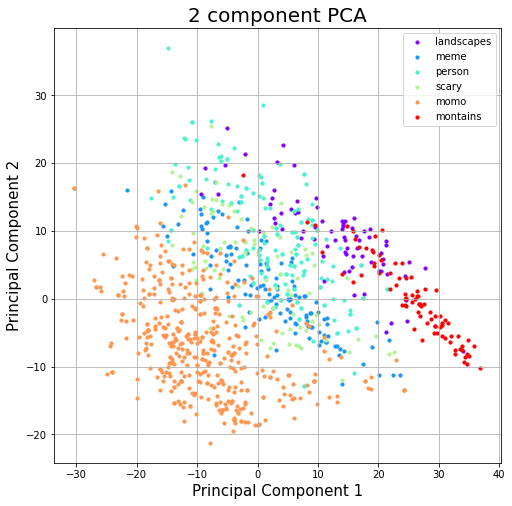

In [23]:
# Plotting using matplot lib

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)

targets = getClasses()
colors = plt.cm.rainbow( np.linspace(0,1,len(getClasses())) )
for target, color in zip(targets,colors):
    indicesToKeep = resultDF['class'] == target    
    ax.scatter(principalComponents[indicesToKeep][:,0:1]
               , principalComponents[indicesToKeep][:,1:2]
               , color = color
               , s = 10)
ax.legend(targets)
ax.grid()